<a href="https://colab.research.google.com/github/StellaIbeh/Time_series_forecasting/blob/main/Adaobi_Stella_Ibeh_air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD as sdg
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [69]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Beijing Air Quality Forecasting Starter Notebook

In [70]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle Competition/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle Competition/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [40]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()



Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427


In [41]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')

In [42]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)



KeyError: 'datetime'

In [38]:
# Ensure 'datetime' column is in datetime format
# train['datetime'] = pd.to_datetime(train['datetime'])  # This line was causing the error because 'datetime' is now the index
# Change to:
train.index = pd.to_datetime(train.index) # Convert the index to datetime

test.index = pd.to_datetime(test.index) # Convert the index to datetime


# The rest of your code should work as expected since you are already using the index for time-series handling
# train.set_index('datetime', inplace=True)  # This is no longer needed
# val.set_index('datetime', inplace=True)
# test.set_index('datetime', inplace=True)

In [43]:
# Summarize the train and test data
print("Summary of Train Data:")
print(train.describe()) # Change train_data to train

print("\nSummary of Test Data:")
print(test.describe())  # Change test_data to test

Summary of Train Data:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.0

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [44]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


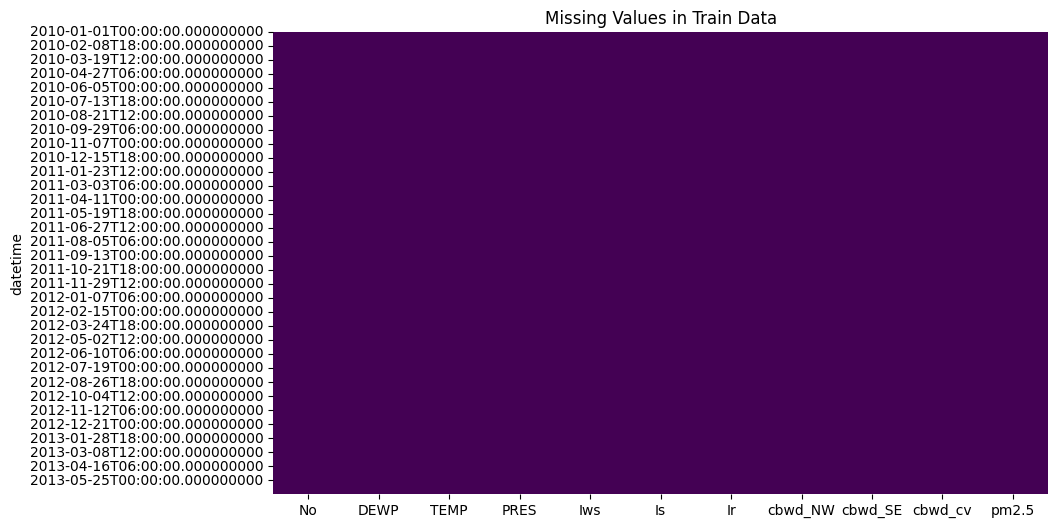

In [22]:
# Check for missing values
missing_values = train.isnull().sum()  # Changed 'train_data' to 'train'
# Visualizing missing values
plt.figure(figsize=(10, 6))
import seaborn as sns # added import statement for seaborn
sns.heatmap(train.isnull(), cbar=False, cmap='viridis') # Changed 'train_data' to 'train'
plt.title("Missing Values in Train Data")
plt.show()

Observations

Missing Values:

The pm2.5 column has notable missing values, as seen in the heatmap. These need to be handled carefully since they directly affect the target predictions. No significant missingness is observed in other columns.

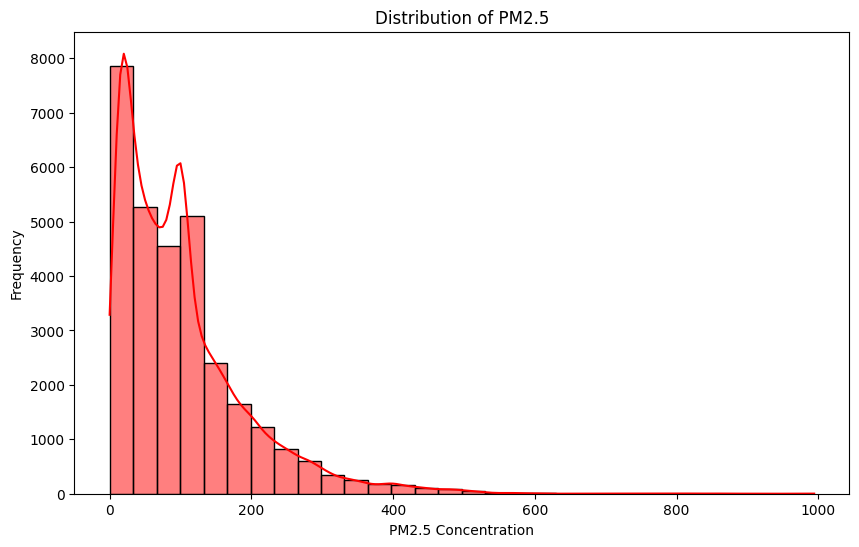

In [ ]:
# Distribution of pm2.5
plt.figure(figsize=(10, 6))
sns.histplot(train['pm2.5'], kde=True, bins=30, color='red')
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 Concentration")
plt.ylabel("Frequency")
plt.show()

Observation:
PM2.5 Distribution:

The distribution of pm2.5 is skewed, indicating outliers. This skewness might affect model performance.

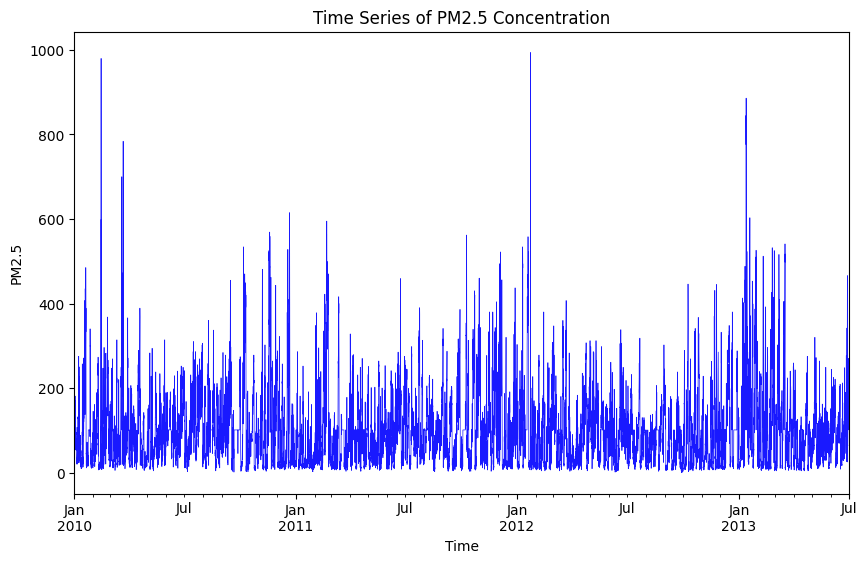

In [ ]:
# Convert datetime column to datetime type
# train['datetime'] = pd.to_datetime(train['datetime']) # This line is causing the error
# Change to
# train.index = pd.to_datetime(train.index) # Convert the index to datetime

# Replace train_data with train
train.index = pd.to_datetime(train.index)

# Time-series plot for PM2.5
plt.figure(figsize=(10, 6))
train['pm2.5'].plot(linewidth=0.5, color='blue', alpha=0.9)  # Use train instead of train_data
plt.title("Time Series of PM2.5 Concentration")
plt.ylabel("PM2.5")
plt.xlabel("Time")
plt.show()

Observation The time series plot of PM2.5 concentration (2010–2013) shows high variability, with frequent fluctuations and occasional extreme peaks (above 1000).


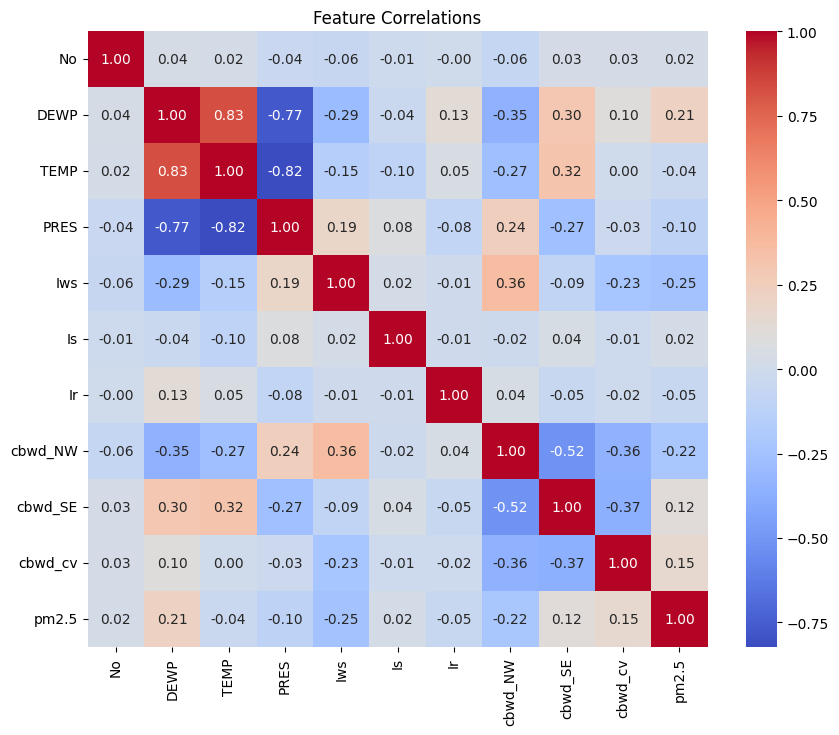

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

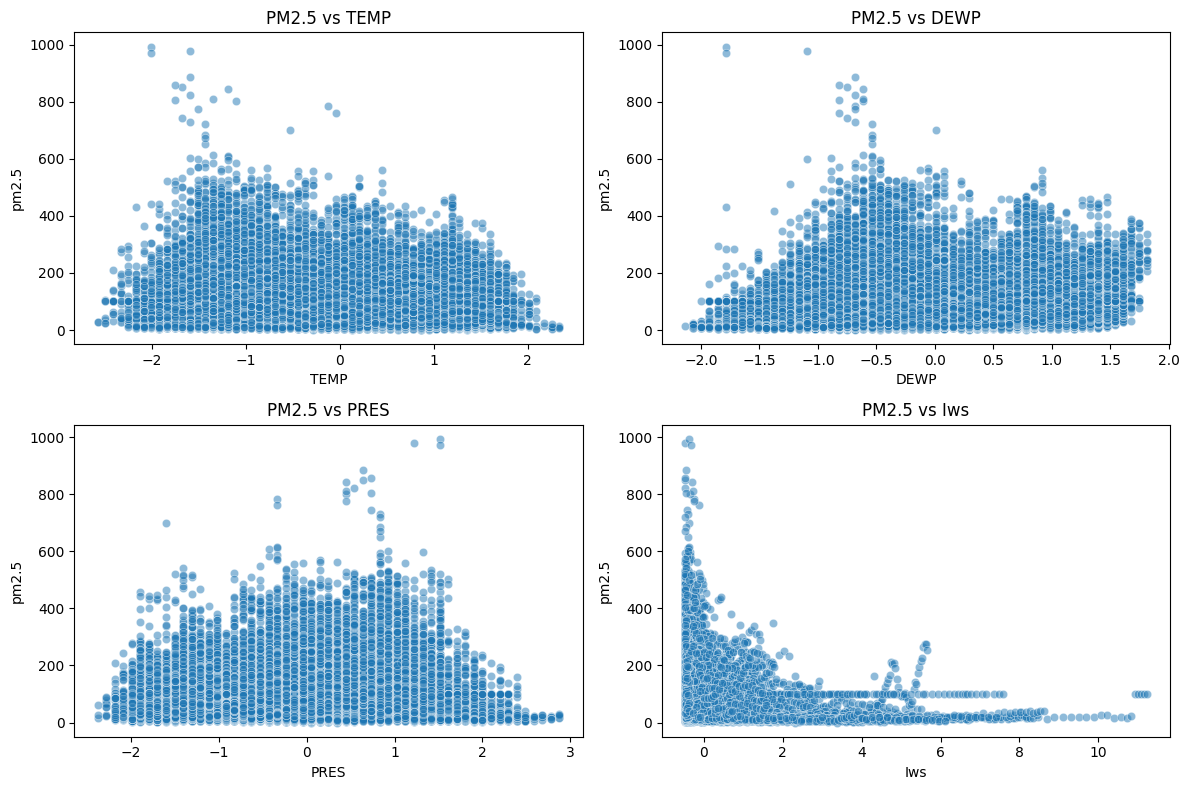

In [ ]:
# Scatter plots for key features against pm2.5
features_to_plot = ['TEMP', 'DEWP', 'PRES', 'Iws']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=train, x=feature, y='pm2.5', alpha=0.5)
    plt.title(f"PM2.5 vs {feature}")
plt.tight_layout()
plt.show()

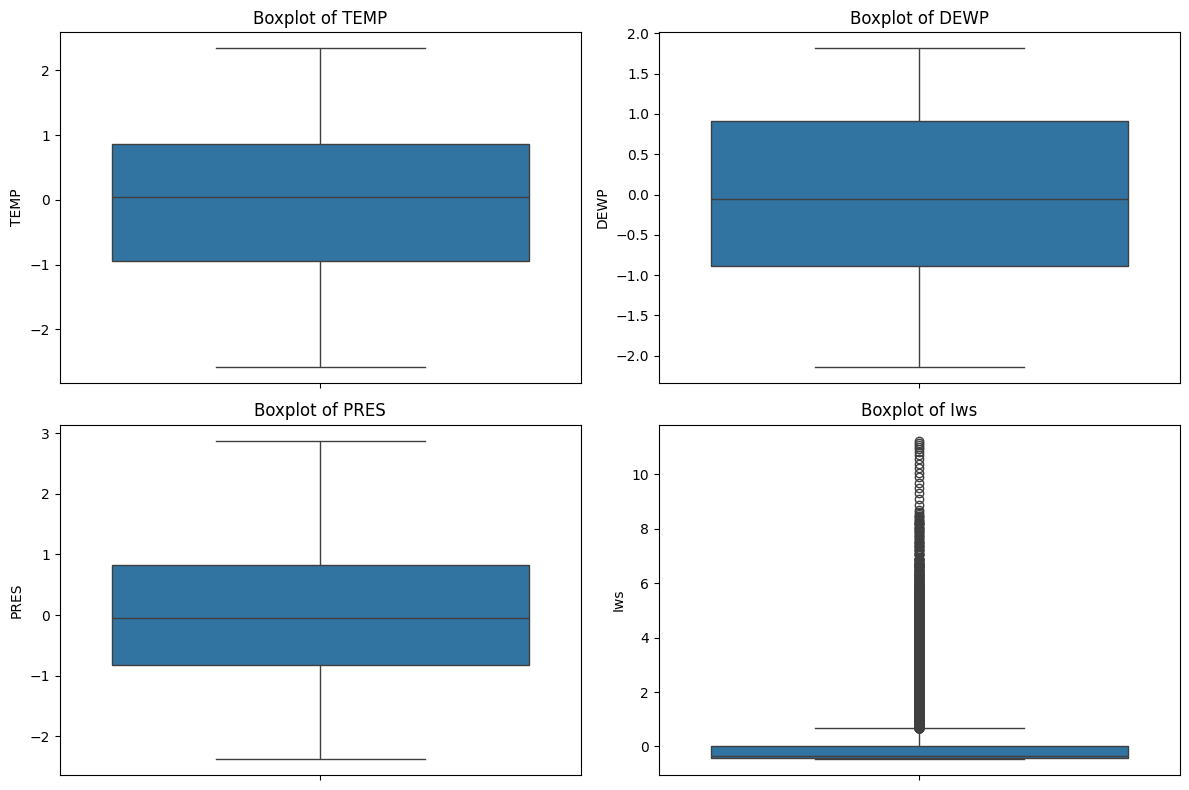

In [ ]:

# Boxplots for detecting outliers
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=train, y=feature)
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [23]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [33]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
# Using tf.keras.metrics.RootMeanSquaredError with a specific name
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Display the model architecture
model.summary()

# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 32)                  │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 17396.5605 - rmse: 131.8111
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9171.7139 - rmse: 95.7299
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7289.1797 - rmse: 85.3636
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6104.7134 - rmse: 78.1186
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5956.3359 - rmse: 77.1298
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5721.6660 - rmse: 75.6339
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5402.0156 - rmse: 73.4941
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5297.8633 - rmse: 72.7584
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5667.5454 - rmse: 75.2706
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5519.2319 - rmse: 74.2765
Training RMSE: 73.75865173339844


In [47]:
# Reshape X_train to the correct shape (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[-1])

Model 9


In [48]:

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(1)  # Single output for regression (air quality prediction)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Adam optimizer with a learning rate of 0.0005
    loss='mse',  # Mean Squared Error for regression tasks
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


# Train the model
history = model.fit(
    X_train, y_train,  # Use scaled data
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                       │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 13909.0039 - rmse: 117.5145 - val_loss: 10208.0508 - val_rmse: 101.0349 - learning_rate: 5.0000e-04
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6089.2773 - rmse: 78.0207 - val_loss: 8545.3242 - val_rmse: 92.4409 - learning_rate: 5.0000e-04
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5901.3252 - rmse: 76.7761 - val_loss: 8049.9702 - val_rmse: 89.7216 - learning_rate: 5.0000e-04
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5307.1406 - rmse: 72.8342 - val_loss: 7540.1943 - val_rmse: 86.8343 - learning_rate: 5.0000e-04
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5201.4634 - rmse: 72.1130 - val_loss: 7447.2275 - val_rmse: 86.2973 - learning_rate: 5.0000e-04
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5189.5669 - rmse: 72.0166 - val_loss: 7270.3691 - val_rmse: 85.2665 - learning_rate: 5.0000e-04
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 

Model 10

In [25]:

# Model architecture
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),

    LSTM(32, return_sequences=False, activation='relu'),
    BatchNormalization(),

    Dense(16, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse',  # More robust than MSE
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Model summary
model.summary()

# Train the model using the scaled and reshaped data (X_train_scaled, y_train_scaled)
history = model.fit(
    X_train, y_train,  # Use scaled data
    epochs=10,
    batch_size=32,
    validation_split=0.5,
    callbacks=[early_stopping, lr_scheduler]
)

# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 16859.3301 - rmse: 129.8182 - val_loss: 17032.4160 - val_rmse: 130.5083 - learning_rate: 3.0000e-04
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 12411.3662 - rmse: 111.2609 - val_loss: 9545.2021 - val_rmse: 97.6995 - learning_rate: 3.0000e-04
Epoch 3/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 7314.8594 - rmse: 85.5110 - val_loss: 6816.0698 - val_rmse: 82.5595 - learning_rate: 3.0000e-04
Epoch 4/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 5953.6250 - rmse: 77.1361 - val_loss: 6259.3945 - val_rmse: 79.1163 - learning_rate: 3.0000e-04
Epoch 5/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 5370.3896 - rmse: 73.2337 - val_loss: 6288.0938 - val_rmse: 79.2975 - learning_rate: 3.0000e-04
Epoch 6/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 5299.0308 - rmse: 72.7614 - val_loss: 6202.7378 - val_rmse: 78.7575 - learning_rate: 3.0000e-04
Epoch 7/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms

Model 11


In [26]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
    Dropout(0.3),

    LSTM(32, return_sequences=False, activation='tanh'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Final output for regression
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

model.summary()


# Training the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)

# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 14284.0840 - rmse: 119.0401 - learning_rate: 1.0000e-04
Epoch 2/50
   7/1918 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - loss: 9242.0225 - rmse: 95.9665

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,learning_rate.
  callback.on_epoch_end(epoch, logs)


1918/1918 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 6921.2021 - rmse: 83.1621 - learning_rate: 1.0000e-04
Epoch 3/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 6226.3350 - rmse: 78.9003 - learning_rate: 1.0000e-04
Epoch 4/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 5949.2319 - rmse: 77.1209 - learning_rate: 1.0000e-04
Epoch 5/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 6063.7207 - rmse: 77.8603 - learning_rate: 1.0000e-04
Epoch 6/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 5959.5664 - rmse: 77.1779 - learning_rate: 1.0000e-04
Epoch 7/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 5796.5020 - rmse: 76.1262 - learning_rate: 1.0000e-04
Epoch 8/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 5769.4956 - rmse: 75.9517 - learning_rate: 1.0000e-04
Epoch 9/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 5791.4224 - rmse: 76.0959 - learning_rate: 1.0000e-04
Epoch 10/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 59

Model 12

In [27]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(1)  # Single output for regression (air quality prediction)
])

# Compile the model
model.compile(
    optimizer=sdg(learning_rate=0.001),  # SDG optimizer with a learning rate of 0.001
    loss='mse',  # Mean Squared Error for regression tasks
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


# Train the model using the scaled and reshaped data (X_train_scaled, y_train_scaled)
history = model.fit(
    X_train, y_train,  # Use scaled data
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,297 (356.63 KB)

 Trainable params: 91,297 (356.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 8150.8789 - rmse: 89.3372 - val_loss: 7534.2417 - val_rmse: 86.8000 - learning_rate: 0.0010
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 5172.5127 - rmse: 71.9152 - val_loss: 7553.6787 - val_rmse: 86.9119 - learning_rate: 0.0010
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5037.4771 - rmse: 70.9668 - val_loss: 6915.6621 - val_rmse: 83.1605 - learning_rate: 0.0010
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4842.0049 - rmse: 69.5812 - val_loss: 7043.8228 - val_rmse: 83.9275 - learning_rate: 0.0010
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 4838.4253 - rmse: 69.5385 - val_loss: 8348.3477 - val_rmse: 91.3693 - learning_rate: 0.0010
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4827.0332 - rmse: 69.4679 - val_loss: 7134.0034 - val_rmse: 84.4630 - learning_rate: 0.0010
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 4758.7451 - rmse: 68.9796 -

In [28]:
print(X_train.shape)


(30676, 1, 9)


In [29]:
X_train = np.expand_dims(X_train, axis=1)  # Assuming 1 timestep


Model 13


In [49]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model w
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)


#Display the model architecture
model.summary()

#Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
)

# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 12497.3223 - rmse: 111.0511 - val_loss: 8908.2070 - val_rmse: 94.3833
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5986.6909 - rmse: 77.3665 - val_loss: 7840.7158 - val_rmse: 88.5478
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5466.0435 - rmse: 73.9221 - val_loss: 7444.5103 - val_rmse: 86.2816
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5538.6572 - rmse: 74.4018 - val_loss: 7404.6030 - val_rmse: 86.0500
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5105.8184 - rmse: 71.4431 - val_loss: 7078.6719 - val_rmse: 84.1348
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5054.0605 - rmse: 71.0692 - val_loss: 7238.3262 - val_rmse: 85.0784
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5361.7432 - rmse: 73.0869 - val_loss: 7067.5796 - val_rmse: 84.0689
Epoch 8/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 5033.5977 - rmse: 70.9396 - val_loss: 6993

Model 14




In [50]:

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model w
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)


#Display the model architecture
model.summary()

#Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
)

#Access Training RSME
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 10290.6357 - rmse: 100.5795 - val_loss: 8134.4937 - val_rmse: 90.1914
Epoch 2/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5446.1143 - rmse: 73.7923 - val_loss: 7371.9204 - val_rmse: 85.8599
Epoch 3/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5365.6523 - rmse: 73.2389 - val_loss: 7236.7471 - val_rmse: 85.0691
Epoch 4/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5267.7798 - rmse: 72.5726 - val_loss: 6986.0200 - val_rmse: 83.5824
Epoch 5/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 5113.2832 - rmse: 71.4937 - val_loss: 6974.0156 - val_rmse: 83.5106
Epoch 6/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5328.8818 - rmse: 72.9882 - val_loss: 6948.7158 - val_rmse: 83.3590
Epoch 7/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5144.6006 - rmse: 71.7192 - val_loss: 6958.4702 - val_rmse: 83.4174
Epoch 8/10
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5173.3301 - rmse: 71

Model 15

In [51]:
# Enhanced LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile with RMSE as a monitored metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11745.4619 - rmse: 107.3502 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,learning_rate
  current = self.get_monitor_value(logs)


959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 5405.0894 - rmse: 73.5076 - learning_rate: 0.0010
Epoch 3/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5288.3799 - rmse: 72.7120 - learning_rate: 0.0010
Epoch 4/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 5211.9360 - rmse: 72.1843 - learning_rate: 0.0010
Epoch 5/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5093.4902 - rmse: 71.3594 - learning_rate: 0.0010
Epoch 6/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5213.7783 - rmse: 72.1987 - learning_rate: 0.0010
Epoch 7/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 5024.0854 - rmse: 70.8588 - learning_rate: 0.0010
Epoch 8/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5136.1143 - rmse: 71.6609 - learning_rate: 0.0010
Epoch 9/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5169.6860 - rmse: 71.8894 - learning_rate: 0.0010
Epoch 10/30
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 5010.4141 - rmse: 70.7738 - learning_rate: 0.0010
Epoch 11/30
959/959 

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


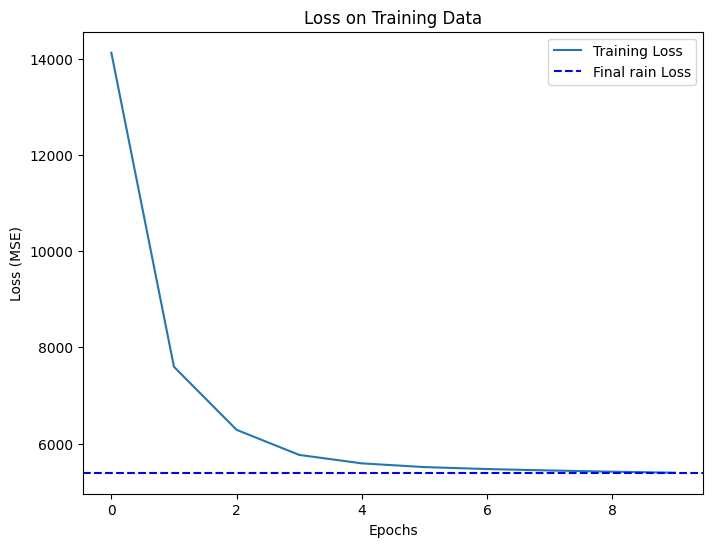

Final Training Loss (MSE): 5380.180645503448


In [ ]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # Reshape directly
# Use X_test.shape[1] which represents the timesteps from the original X_test shape,
# instead of a hardcoded value like 9.

In [ ]:
print(X_train.shape)


(30676, 1, 9)


Model 16

In [52]:


# Improved LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model with a lower initial learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Increased number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,793 (522.63 KB)

 Trainable params: 133,409 (521.13 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 15186.1797 - rmse: 123.0615 - val_loss: 11242.3545 - val_rmse: 106.0300 - learning_rate: 5.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6354.3198 - rmse: 79.6951 - val_loss: 7883.6104 - val_rmse: 88.7897 - learning_rate: 5.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 5204.7734 - rmse: 72.1138 - val_loss: 7515.2529 - val_rmse: 86.6906 - learning_rate: 5.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 5127.3726 - rmse: 71.5966 - val_loss: 7283.3320 - val_rmse: 85.3424 - learning_rate: 5.0000e-04
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 5014.5200 - rmse: 70.8048 - val_loss: 7268.3540 - val_rmse: 85.2546 - learning_rate: 5.0000e-04
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 4953.4609 - rmse: 70.3663 - val_loss: 7070.7437 - val_rmse: 84.0877 - learning_rate: 5.0000e-04
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step -

Model 17

In [53]:


# Further Enhanced LSTM model
model = Sequential([
    # First LSTM layer with more units and dropout
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM layer
    LSTM(32, activation='tanh', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    # Fully connected layers for feature extraction
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),

    # Output layer for regression
    Dense(1)  # Output layer
])

# Compile the model with lower learning rate for smoother convergence
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=70,  # Increased epochs to allow more learning
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,601 (537.50 KB)

 Trainable params: 137,153 (535.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 13165.6436 - rmse: 113.9595 - val_loss: 7273.8184 - val_rmse: 85.2867 - learning_rate: 3.0000e-04
Epoch 2/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 5706.3599 - rmse: 75.5201 - val_loss: 7099.7612 - val_rmse: 84.2601 - learning_rate: 3.0000e-04
Epoch 3/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 5606.6909 - rmse: 74.8621 - val_loss: 7004.1309 - val_rmse: 83.6907 - learning_rate: 3.0000e-04
Epoch 4/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 5349.1289 - rmse: 73.1301 - val_loss: 6928.6885 - val_rmse: 83.2387 - learning_rate: 3.0000e-04
Epoch 5/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 5495.6685 - rmse: 74.1131 - val_loss: 7044.9878 - val_rmse: 83.9344 - learning_rate: 3.0000e-04
Epoch 6/70
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 5333.3584 - rmse: 73.0107 - val_loss: 7015.3062 - val_rmse: 83.7574 - learning_rate: 3.0000e-04
Epoch 7/70
766/767 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Model 18

In [54]:


# Further Enhanced LSTM model
model = Sequential([
    # First LSTM layer with more units and dropout
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Fully connected layers for feature extraction
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),

    # Output layer for regression
    Dense(1)  # Output layer
])

# Compile the model with lower learning rate for smoother convergence
model.compile(
    optimizer=RMSprop(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased epochs to allow more learning
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1, 32)               │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,105 (496.50 KB)

 Trainable params: 126,721 (495.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 12485.9297 - rmse: 111.2459 - val_loss: 7685.7554 - val_rmse: 87.6684 - learning_rate: 3.0000e-04
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5599.1240 - rmse: 74.8091 - val_loss: 7294.0874 - val_rmse: 85.4054 - learning_rate: 3.0000e-04
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 5482.4224 - rmse: 74.0138 - val_loss: 7080.5757 - val_rmse: 84.1462 - learning_rate: 3.0000e-04
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5573.7729 - rmse: 74.6510 - val_loss: 7170.1367 - val_rmse: 84.6767 - learning_rate: 3.0000e-04
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 5466.1797 - rmse: 73.9272 - val_loss: 6958.1968 - val_rmse: 83.4158 - learning_rate: 3.0000e-04
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 5157.7222 - rmse: 71.8021 - val_loss: 6939.9072 - val_rmse: 83.3061 - learning_rate: 3.0000e-04
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - lo

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


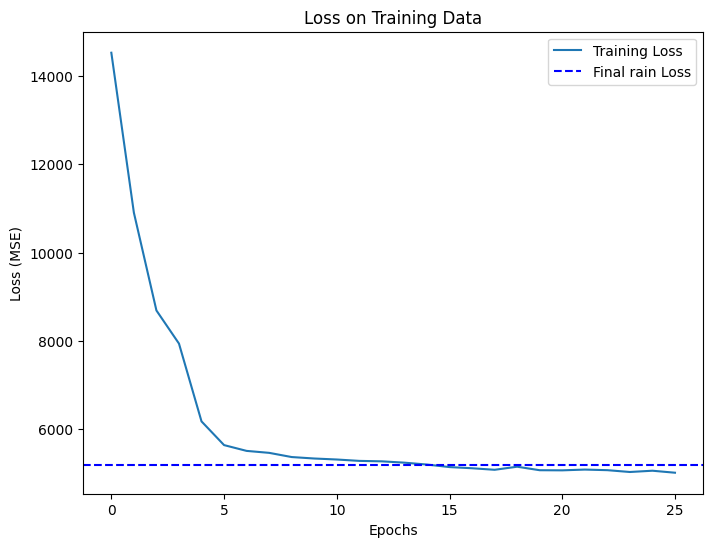

Final Training Loss (MSE): 5197.917937097179


In [ ]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

Model 19

In [55]:
model = Sequential([
    # First LSTM layer with more units and dropout
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(64, activation='tanh', return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Fully connected layers for feature extraction
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),

    # Output layer for regression
    Dense(1)  # Output layer
])

# Compile the model with lower learning rate for smoother convergence
model.compile(
    optimizer=sdg(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Increased epochs to allow more learning
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_42 (LSTM)                       │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1, 32)               │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,105 (496.50 KB)

 Trainable params: 126,721 (495.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7645.5127 - rmse: 87.2557 - val_loss: 8716.8848 - val_rmse: 93.3643 - learning_rate: 3.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6411.1631 - rmse: 80.0385 - val_loss: 8100.2261 - val_rmse: 90.0013 - learning_rate: 3.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5663.6797 - rmse: 75.2258 - val_loss: 7938.5503 - val_rmse: 89.0985 - learning_rate: 3.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 5577.4092 - rmse: 74.6677 - val_loss: 7908.4282 - val_rmse: 88.9293 - learning_rate: 3.0000e-04
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5692.2900 - rmse: 75.4385 - val_loss: 7980.5732 - val_rmse: 89.3341 - learning_rate: 3.0000e-04
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 5496.3809 - rmse: 74.1313 - val_loss: 8131.4849 - val_rmse: 90.1747 - learning_rate: 3.0000e-04
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5

Model 20

In [57]:
 #Define the model
model = Sequential([
    # First LSTM layer with L2 regularizer and BatchNormalization
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout to prevent overfitting

    # Second LSTM layer with L2 regularizer and BatchNormalization
    LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    # Fully connected layer with ReLU activation
    Dense(1, activation='relu')  # Output layer with ReLU activation
])

# Compile the model with Adam optimizer and learning rate 0.0003
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Epochs set to 50
    batch_size=32,  # Batch size set to 32
    validation_split=0.2,
    callbacks=callbacks
)

# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,897 (472.25 KB)

 Trainable params: 120,513 (470.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 15788.9492 - rmse: 125.6140 - val_loss: 19663.4648 - val_rmse: 140.2213 - learning_rate: 3.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 12640.3594 - rmse: 112.4047 - val_loss: 14800.2842 - val_rmse: 121.6501 - learning_rate: 3.0000e-04
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 10039.6250 - rmse: 100.1626 - val_loss: 12833.9648 - val_rmse: 113.2802 - learning_rate: 3.0000e-04
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 8963.1143 - rmse: 94.6591 - val_loss: 12275.7188 - val_rmse: 110.7885 - learning_rate: 3.0000e-04
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 8965.5801 - rmse: 94.6622 - val_loss: 11922.0713 - val_rmse: 109.1804 - learning_rate: 3.0000e-04
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9182.0205 - rmse: 95.7963 - val_loss: 11871.7461 - val_rmse: 108.9492 - learning_rate: 3.0000e-04
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s

Model 21

In [58]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(1)  # Single output for regression (air quality prediction)
])

# Compile the model
model.compile(
    optimizer=sdg(learning_rate=0.001),  # SDG optimizer with a learning rate of 0.001
    loss='mse',  # Mean Squared Error for regression tasks
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


# Train the model using the scaled and reshaped data (X_train_scaled, y_train_scaled)
history = model.fit(
    X_train, y_train,  # Use scaled data
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_47 (LSTM)                       │ (None, 1, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,297 (356.63 KB)

 Trainable params: 91,297 (356.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8119.5586 - rmse: 89.0979 - val_loss: 7085.6553 - val_rmse: 84.1763 - learning_rate: 0.0010
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5348.1284 - rmse: 73.0794 - val_loss: 7320.2842 - val_rmse: 85.5587 - learning_rate: 0.0010
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 4985.4814 - rmse: 70.5964 - val_loss: 7361.6250 - val_rmse: 85.7999 - learning_rate: 0.0010
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4833.3232 - rmse: 69.5142 - val_loss: 7139.2759 - val_rmse: 84.4942 - learning_rate: 0.0010
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5073.9424 - rmse: 71.2174 - val_loss: 7085.4985 - val_rmse: 84.1754 - learning_rate: 0.0010
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4775.8540 - rmse: 69.0957 - val_loss: 7100.2944 - val_rmse: 84.2632 - learning_rate: 0.0010
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4793.6069 - rmse: 69.2078 - 

Model 22

In [61]:


# Define the enhanced LSTM model
model = Sequential([
    # Bidirectional LSTM layer with L2 regularization, BatchNormalization
    Bidirectional(LSTM(128, activation='relu', return_sequences=True,
                        input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01))),
    BatchNormalization(),


    # Stacked LSTM layer with L2 regularization, BatchNormalization,
    Bidirectional(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),


    # Dense layer with 1 unit and no activation for regression
    Dense(1)  # Output layer
])

# Compile the model with Adam optimizer and learning rate scheduler
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mse',  # Mean Squared Error for regression
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]  # RMSE metric
)

# Display the model architecture
model.summary()

# Callbacks for early stopping and learning rate reduction
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Train the model with training and validation data
history = model.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs set to 10
    batch_size=32,  # Batch size set to 32
    validation_split=0.2,  # Validation split during training
    callbacks=callbacks  # Callbacks for early stopping and learning rate reduction
)
# Access Training RSME using the specified name 'rmse'
train_rmse = history.history['rmse'][-1]
print(f"Training RMSE: {train_rmse}")  # RMSE metric


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 15522.8740 - rmse: 124.5528 - val_loss: 17124.0195 - val_rmse: 130.8424 - learning_rate: 3.0000e-04
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 11646.2695 - rmse: 107.8280 - val_loss: 11038.3848 - val_rmse: 105.0427 - learning_rate: 3.0000e-04
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 7633.2031 - rmse: 87.2990 - val_loss: 7855.9731 - val_rmse: 88.6083 - learning_rate: 3.0000e-04
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 5235.3574 - rmse: 72.3144 - val_loss: 6978.1807 - val_rmse: 83.5076 - learning_rate: 3.0000e-04
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 4720.1938 - rmse: 68.6592 - val_loss: 7040.9907 - val_rmse: 83.8823 - learning_rate: 3.0000e-04
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 4739.3198 - rmse: 68.8016 - val_loss: 6984.9683 - val_rmse: 83.5471 - learning_rate: 3.0000e-04
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 

959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


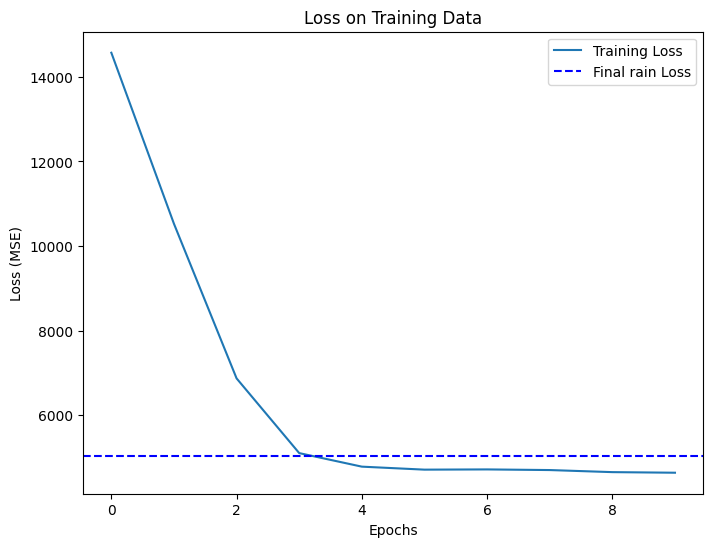

Final Training Loss (MSE): 5030.691172187206


In [62]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [63]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle Competition/subm_fixed_23.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [64]:
submission

,row ID,pm2.5
6,2013-07-02 10:00:00,31
7,2013-07-02 11:00:00,30
8,2013-07-02 12:00:00,26
9,2013-07-02 13:00:00,27
10,2013-07-02 14:00:00,25
...,...,...
13129,2014-12-31 5:00:00,17
13130,2014-12-31 6:00:00,15
13131,2014-12-31 7:00:00,18
13132,2014-12-31 8:00:00,19
